In [2]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data as td
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as colors

froot = './data/k562_chr16'

df = pd.read_csv(froot + ".csv")

In [3]:
print(df.head())

   seqnames   start     end strand  ensembl_gene_id  score      ctcf  \
0        16  245089  245089      +  ENSG00000167930    0.0 -0.039744   
1        16  245090  245090      +  ENSG00000167930    0.0 -0.039511   
2        16  245091  245091      +  ENSG00000167930    0.0 -0.039276   
3        16  245092  245092      +  ENSG00000167930    0.0 -0.039039   
4        16  245093  245093      +  ENSG00000167930    0.0 -0.038799   

   h3k36me3   h3k4me1  h3k79me2  ...       sj3       dms      rpts      wgbs  \
0 -0.429633  0.843669  0.003958  ... -0.057178 -0.307549  0.249626  0.000000   
1 -0.431173  0.851792  0.004639  ... -0.057178 -0.307549  0.249626  0.550271   
2 -0.432698  0.859971  0.005313  ... -0.057178 -0.307549  0.249626  0.000000   
3 -0.434205  0.868205  0.005981  ... -0.057178 -0.307549  0.249626  0.000000   
4 -0.435697  0.876495  0.006642  ... -0.057178 -0.307549  0.249626  0.000000   

       A         T         G         C  lambda_alphaj      zeta  
0 -0.625 -0.678443  

In [5]:
column_names = np.array(df.columns)
feature_names = column_names[6:-6]
num_features = len(feature_names)
nucleotides = column_names[-6:-2]
print(feature_names)
print(nucleotides)
num_samples = df.shape[0]

# process read counts
X_ji = df['score'].values

# process GLM simulated elongation rates
Z_ji = df['zeta'].values

['ctcf' 'h3k36me3' 'h3k4me1' 'h3k79me2' 'h3k9me1' 'h3k9me3' 'h4k20me1'
 'sj5' 'sj3' 'dms' 'rpts' 'wgbs']
['A' 'T' 'G' 'C']


In [6]:
print("Number of Samples: " + str(num_samples))

Number of Samples: 435797


In [7]:
print("Number of Features: " + str(num_features))

Number of Features: 12


In [8]:
#Y_ji is a list of samples containing lists of their feature values
    # [   
    #   sample_1: [feat_1, feat_2,...,feat_n],
    #   sample_2: [feat_1, feat_2,...,feat_n],
    # ]

Y_ji = df.iloc[:, 6:-6].values

In [9]:
C_j = df['lambda_alphaj'].values

In [10]:
cuda_available = torch.cuda.is_available()
print("CUDA (GPU support) is available:", cuda_available)
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)

CUDA (GPU support) is available: False
Number of GPUs available: 0


In [11]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, Y_ji, X_ji, C_j, Z_ji):
        self.Y_ji = Y_ji
        self.X_ji = X_ji
        self.C_j = C_j
        self.Z_ji = Z_ji

    def __len__(self):
        return len(self.Y_ji)

    def __getitem__(self, idx):
        return {
            'Y_ji':  torch.tensor(self.Y_ji[idx], dtype=torch.float32),
            'X_ji': torch.tensor(self.X_ji[idx], dtype=torch.float32),
            'C_j': torch.tensor(self.C_j[idx], dtype=torch.float32),
            'Z_ji': torch.tensor(self.Z_ji[idx], dtype=torch.float32)
        }

In [24]:
dataset = CustomDataset(Y_ji, X_ji, C_j, Z_ji)

train_percent = 0.8
val_percent = 0.1
test_percent = 0.1
train_size = int(train_percent * num_samples)
val_size = int(val_percent * num_samples)
test_size = num_samples - train_size - val_size
#trnset, valset, tstset = td.random_split(dataset, [train_size, val_size, test_size])
trnset = torch.utils.data.Subset(dataset, range(train_size))
valset = torch.utils.data.Subset(dataset, range(train_size, train_size + val_size))
tstset = torch.utils.data.Subset(dataset, range(train_size + val_size, train_size + val_size + test_size))


batch_size = 64

In [25]:
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = nn.Linear(num_features, 1)

if cuda_available:
    if num_gpus > 1:
        print("Using", num_gpus, "GPUs")
        model = torch.nn.DataParallel(model)
    model = model.to('cuda')

print(model)

arr = torch.randn((batch_size,num_features)).to(device)
print(model(arr).shape)
nparm = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: " + str(nparm))

first_param_device = next(model.parameters()).device
print("Model is on device:", first_param_device)

Linear(in_features=12, out_features=1, bias=True)
torch.Size([64, 1])
Number of parameters: 13
Model is on device: cpu


In [26]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, X_ji, C_j, rho_ji):
        #print(rho_ji.shape)
        epsilon = 1e-8
        loss = X_ji * rho_ji + C_j * torch.exp(-rho_ji)
        return (loss).mean()

In [30]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 50

loss_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs

loss_fn = CustomLoss()

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    model.train()
    trndl = DataLoader(trnset, batch_size=batch_size, num_workers=7, shuffle=False, pin_memory=True)
    for i, batch in enumerate(trndl):
        optimizer.zero_grad()
        Y_ji_batch = batch['Y_ji'].to(device)
        X_ji_batch = batch['X_ji'].to(device)
        C_j_batch = batch['C_j'].to(device)
        outputs = model(Y_ji_batch)
        loss = loss_fn(X_ji_batch, C_j_batch, outputs)
        loss.backward()
        optimizer.step()
        loss_hist_train[epoch] += loss.item()
    loss_hist_train[epoch] /= len(trndl)
    del trndl
    
    model.eval()
    valdl = DataLoader(valset, batch_size=batch_size, num_workers=7, shuffle=False, pin_memory=True)
    with torch.no_grad():
        for batch in valdl:
            Y_ji_batch = batch['Y_ji'].to(device)
            X_ji_batch = batch['X_ji'].to(device)
            C_j_batch = batch['C_j'].to(device)
            outputs = model(Y_ji_batch)
            loss = loss_fn(X_ji_batch, C_j_batch, outputs)
            loss_hist_valid[epoch] += loss.item()
        loss_hist_valid[epoch] /= len(valdl)
    del valdl
    
    print(f'Epoch {epoch+1} trn_loss: '
          f'{loss_hist_train[epoch]:.4f} val_loss: '
          f'{loss_hist_valid[epoch]:.4f}')

Epoch 1
Epoch 1 trn_loss: 1.5604 val_loss: 0.0076
Epoch 2
Epoch 2 trn_loss: 1.0605 val_loss: 0.0075
Epoch 3
Epoch 3 trn_loss: 0.7116 val_loss: 0.0074
Epoch 4
Epoch 4 trn_loss: 0.4738 val_loss: 0.0073
Epoch 5
Epoch 5 trn_loss: 0.3134 val_loss: 0.0073
Epoch 6
Epoch 6 trn_loss: 0.2066 val_loss: 0.0072
Epoch 7
Epoch 7 trn_loss: 0.1367 val_loss: 0.0072
Epoch 8
Epoch 8 trn_loss: 0.0917 val_loss: 0.0071
Epoch 9
Epoch 9 trn_loss: 0.0635 val_loss: 0.0071
Epoch 10
Epoch 10 trn_loss: 0.0463 val_loss: 0.0071
Epoch 11
Epoch 11 trn_loss: 0.0363 val_loss: 0.0071
Epoch 12
Epoch 12 trn_loss: 0.0305 val_loss: 0.0071
Epoch 13
Epoch 13 trn_loss: 0.0271 val_loss: 0.0071
Epoch 14
Epoch 14 trn_loss: 0.0250 val_loss: 0.0071
Epoch 15
Epoch 15 trn_loss: 0.0236 val_loss: 0.0071
Epoch 16
Epoch 16 trn_loss: 0.0226 val_loss: 0.0071
Epoch 17
Epoch 17 trn_loss: 0.0220 val_loss: 0.0070
Epoch 18
Epoch 18 trn_loss: 0.0216 val_loss: 0.0070
Epoch 19
Epoch 19 trn_loss: 0.0213 val_loss: 0.0070
Epoch 20
Epoch 20 trn_loss: 0.

In [16]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"models/Elongation_Model_chr16_{timestamp}.pth"
torch.save(model.state_dict(), filename)

In [107]:
"""
model = nn.Linear(num_features, 1)
model.load_state_dict(torch.load("models/Elongation_Model.pth"))
cuda_available = torch.cuda.is_available()
print("CUDA (GPU support) is available:", cuda_available)
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)
if cuda_available:
    if num_gpus > 1:
        print("Using", num_gpus, "GPUs")
        model = torch.nn.DataParallel(model)
    model = model.to('cuda')

first_param_device = next(model.parameters()).device
print("Model is on device:", first_param_device)
"""

CUDA (GPU support) is available: True
Number of GPUs available: 1
Model is on device: cuda:0


In [31]:
weights = model.weight.data.cpu().numpy()
bias = model.bias.data.cpu().numpy()

combined = ', '.join([f'"{s}": {f}' for s, f in zip(feature_names, weights[0])])
print(combined)

"ctcf": -0.021397870033979416, "h3k36me3": -0.05592929199337959, "h3k4me1": -0.007195422425866127, "h3k79me2": 0.08613084256649017, "h3k9me1": -0.05701635405421257, "h3k9me3": -0.08556307852268219, "h4k20me1": -0.09722592681646347, "sj5": -0.020360343158245087, "sj3": -0.014966409653425217, "dms": -0.07458958029747009, "rpts": 0.017763584852218628, "wgbs": 0.005986951291561127


In [ ]:
# GLM K (chr 16)



<function matplotlib.pyplot.show(close=None, block=None)>

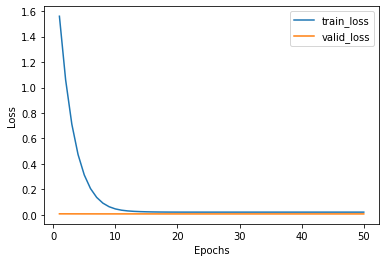

In [32]:
from matplotlib import pyplot as plt
epochs = range(1, len(loss_hist_train) + 1)
plt.plot(epochs, loss_hist_train, label='train_loss')
plt.plot(epochs, loss_hist_valid, label='valid_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show 

In [33]:
def plot_data(simulated_zeta, predicted_zeta):
    indices = range(len(simulated_zeta))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.plot(indices, predicted_zeta, color='blue', alpha=0.4)
    ax.plot(indices, simulated_zeta, color='orange', alpha=0.4)
    
    ax.scatter(indices, predicted_zeta, color='blue', label='Predicted Zeta')
    ax.scatter(indices, simulated_zeta, color='orange', label='Simulated Zeta')
    
    ax.set_title('Predicted vs Simulated Elongation Rate')
    ax.set_xlabel('Index')
    ax.set_ylabel('Elongation Rate')
    ax.legend()

    plt.show()


In [34]:
tstdl = DataLoader(tstset, batch_size=batch_size, num_workers=0, shuffle=False, pin_memory=True)

In [35]:
model.eval()

data_iter = iter(tstdl)

number of samples: 4
predicted zeta:
tensor([0.9862, 0.9863, 0.9865, 0.9866, 0.9867, 0.9869, 0.9870, 0.9872, 0.9874,
        0.9876, 0.9877, 0.9879, 0.9881, 0.9883, 0.9886, 0.9888, 0.9890, 0.9892,
        0.9895, 0.9897, 0.9900, 0.9902, 0.9905, 0.9908, 0.9910, 0.9913, 0.9916,
        0.9919, 0.9922, 0.9925, 0.9928, 0.9932, 0.9935, 0.9938, 0.9942, 0.9945,
        0.9949, 0.9952, 0.9956, 0.9959, 0.9963, 0.9967, 0.9971, 0.9975, 0.9978,
        0.9982, 0.9986, 0.9990, 0.9995, 0.9999, 1.0003, 1.0007, 1.0011, 1.0016,
        1.0020, 1.0024, 1.0029, 1.0033, 1.0038, 1.0042, 1.0047, 1.0051, 1.0056,
        1.0060])
simulated zeta:
tensor([1.0085, 1.0085, 1.0086, 1.0086, 1.0086, 1.0087, 1.0087, 1.0088, 1.0088,
        1.0089, 1.0090, 1.0091, 1.0092, 1.0093, 1.0094, 1.0095, 1.0096, 1.0097,
        1.0098, 1.0100, 1.0101, 1.0103, 1.0104, 1.0106, 1.0107, 1.0109, 1.0111,
        1.0113, 1.0115, 1.0117, 1.0119, 1.0121, 1.0123, 1.0125, 1.0127, 1.0130,
        1.0132, 1.0135, 1.0137, 1.0139, 1.0142, 1.

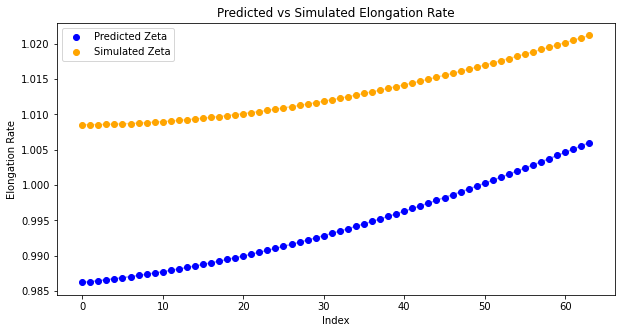

number of samples: 4
predicted zeta:
tensor([1.0065, 1.0070, 1.0074, 1.0079, 1.0084, 1.0088, 1.0093, 1.0098, 1.0103,
        1.0108, 1.0113, 1.0117, 1.0122, 1.0127, 1.0132, 1.0137, 1.0142, 1.0147,
        1.0152, 1.0157, 1.0162, 1.0167, 1.0171, 1.0176, 1.0181, 1.0186, 1.0191,
        1.0196, 1.0201, 1.0206, 1.0211, 1.0216, 1.0221, 1.0226, 1.0231, 1.0235,
        1.0240, 1.0245, 1.0250, 1.0255, 1.0259, 1.0264, 1.0269, 1.0274, 1.0278,
        1.0283, 1.0288, 1.0292, 1.0297, 1.0302, 1.0306, 1.0311, 1.0315, 1.0320,
        1.0324, 1.0329, 1.0333, 1.0337, 1.0342, 1.0346, 1.0350, 1.0354, 1.0359,
        1.0363])
simulated zeta:
tensor([1.0215, 1.0219, 1.0222, 1.0226, 1.0229, 1.0233, 1.0236, 1.0240, 1.0244,
        1.0247, 1.0251, 1.0254, 1.0258, 1.0262, 1.0265, 1.0269, 1.0273, 1.0276,
        1.0280, 1.0284, 1.0287, 1.0291, 1.0295, 1.0298, 1.0302, 1.0306, 1.0309,
        1.0313, 1.0317, 1.0320, 1.0324, 1.0328, 1.0331, 1.0335, 1.0338, 1.0342,
        1.0346, 1.0349, 1.0353, 1.0356, 1.0360, 1.

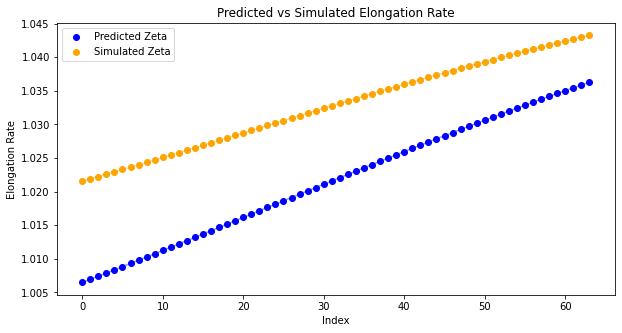

number of samples: 4
predicted zeta:
tensor([1.0367, 1.0371, 1.0375, 1.0379, 1.0383, 1.0387, 1.0391, 1.0394, 1.0398,
        1.0402, 1.0406, 1.0409, 1.0413, 1.0416, 1.0420, 1.0423, 1.0427, 1.0430,
        1.0433, 1.0437, 1.0440, 1.0443, 1.0446, 1.0449, 1.0452, 1.0455, 1.0458,
        1.0461, 1.0464, 1.0466, 1.0469, 1.0472, 1.0474, 1.0477, 1.0479, 1.0482,
        1.0484, 1.0486, 1.0489, 1.0491, 1.0493, 1.0495, 1.0497, 1.0499, 1.0501,
        1.0503, 1.0505, 1.0506, 1.0508, 1.0510, 1.0511, 1.0513, 1.0514, 1.0516,
        1.0517, 1.0518, 1.0519, 1.0521, 1.0522, 1.0523, 1.0524, 1.0525, 1.0526,
        1.0527])
simulated zeta:
tensor([1.0435, 1.0438, 1.0441, 1.0443, 1.0446, 1.0448, 1.0451, 1.0453, 1.0456,
        1.0458, 1.0461, 1.0463, 1.0465, 1.0467, 1.0470, 1.0472, 1.0474, 1.0476,
        1.0478, 1.0480, 1.0482, 1.0483, 1.0485, 1.0487, 1.0489, 1.0490, 1.0492,
        1.0493, 1.0495, 1.0496, 1.0498, 1.0499, 1.0500, 1.0502, 1.0503, 1.0504,
        1.0505, 1.0506, 1.0507, 1.0508, 1.0509, 1.

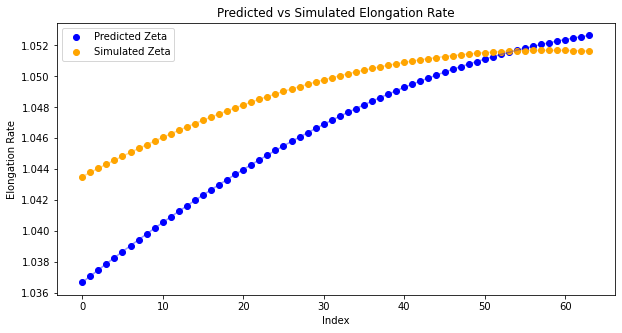

number of samples: 4
predicted zeta:
tensor([1.0527, 1.0528, 1.0529, 1.0529, 1.0530, 1.0530, 1.0531, 1.0531, 1.0532,
        1.0532, 1.0532, 1.0532, 1.0532, 1.0532, 1.0533, 1.0532, 1.0532, 1.0532,
        1.0532, 1.0532, 1.0532, 1.0531, 1.0531, 1.0530, 1.0530, 1.0529, 1.0529,
        1.0528, 1.0527, 1.0527, 1.0526, 1.0525, 1.0524, 1.0523, 1.0522, 1.0521,
        1.0520, 1.0519, 1.0518, 1.0517, 1.0515, 1.0514, 1.0513, 1.0511, 1.0510,
        1.0508, 1.0507, 1.0505, 1.0504, 1.0502, 1.0500, 1.0499, 1.0497, 1.0495,
        1.0493, 1.0491, 1.0489, 1.0487, 1.0485, 1.0483, 1.0481, 1.0479, 1.0477,
        1.0475])
simulated zeta:
tensor([1.0516, 1.0516, 1.0515, 1.0515, 1.0515, 1.0514, 1.0514, 1.0513, 1.0512,
        1.0512, 1.0511, 1.0510, 1.0510, 1.0509, 1.0508, 1.0507, 1.0506, 1.0505,
        1.0504, 1.0503, 1.0502, 1.0501, 1.0500, 1.0499, 1.0498, 1.0497, 1.0495,
        1.0494, 1.0493, 1.0491, 1.0490, 1.0489, 1.0487, 1.0486, 1.0484, 1.0483,
        1.0481, 1.0480, 1.0478, 1.0476, 1.0475, 1.

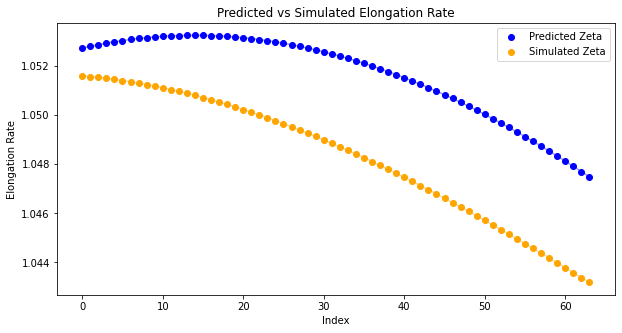

In [37]:
for i in range(0, 4):
    inputs = next(data_iter) 
    print("number of samples: " + str(len(inputs)))

    with torch.no_grad():
        y_inputs = inputs['Y_ji'].to(device)
        rho_ji = model(y_inputs)

    simulated_zeta = inputs['Z_ji']
    # convert log(Z) outputs to Z
    predicted_zeta = torch.exp(rho_ji.cpu().squeeze())
    print("predicted zeta:")
    print(predicted_zeta)

    print("simulated zeta:")
    print(simulated_zeta)

    plot_data(simulated_zeta, predicted_zeta)

In [114]:
import torch.nn.functional as F

predicted_zeta = []
simulated_zeta = []
with torch.no_grad():
    for batch in tstdl:
        y_inputs = batch['Y_ji'].to(device)
        rho_ji = model(y_inputs)
        # convert log(Z) outputs to Z
        predicted_zeta.append(torch.exp(rho_ji.cpu()))
        simulated_zeta.append(batch['Z_ji'])

predicted_zeta = torch.cat(predicted_zeta, dim=0)
simulated_zeta = torch.cat(simulated_zeta, dim=0)
mae = F.l1_loss(predicted_zeta.squeeze(), simulated_zeta)
mse = F.mse_loss(predicted_zeta.squeeze(), simulated_zeta)

print(f"Mean Absolute Error: {mae.item():.4f}")
print(f"Mean Squared Error: {mse.item():.4f}")

Mean Absolute Error: 1.4545
Mean Squared Error: 2.1965
